## Loading training data

In [5]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import shap
import random

C:\Users\Anjana\anaconda3\envs\alzheimers_prediction\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
data = pd.read_parquet("train-00000-of-00001-c08a401c53fe5312.parquet")
data.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


## Data pre-processing

In [9]:
def bytes_to_image(d):
    if isinstance(d, dict) and "bytes" in d:
        bytes_ls = d["bytes"]
        np_ls = np.frombuffer(bytes_ls, np.uint8)
        image = cv2.imdecode(np_ls, cv2.IMREAD_GRAYSCALE)
        return image
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(d)}")

In [11]:
data["img_arr"] = data["image"].apply(bytes_to_image)
data.drop("image", axis = 1, inplace = True)
data.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [13]:
label_to_class_mapping = {0: "Mild_Demented", 1: "Moderate_Demented", 2: "Non_Demented",3: "Very_Mild_Demented"}
data["class"] = data["label"].map(label_to_class_mapping)
data.head()

,label,img_arr,class
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Non_Demented
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mild_Demented
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Very_Mild_Demented
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Very_Mild_Demented
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Non_Demented


## Model training

In [15]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size = 0.2, stratify = data["class"], random_state = 42)

train_data.shape, val_data.shape

((4096, 3), (1024, 3))

In [17]:
X_train = np.stack(train_data["img_arr"].values)
y_train = train_data["label"].values
X_val = np.stack(val_data["img_arr"].values)
y_val = val_data["label"].values

X_train = X_train.reshape(-1, 128, 128, 1)
X_val = X_val.reshape(-1, 128, 128, 1)

In [21]:
model = tf.keras.models.load_model("cnn_data_augmentation_model.keras") 

## SHAP model explainability

<Figure size 2000x2000 with 0 Axes>

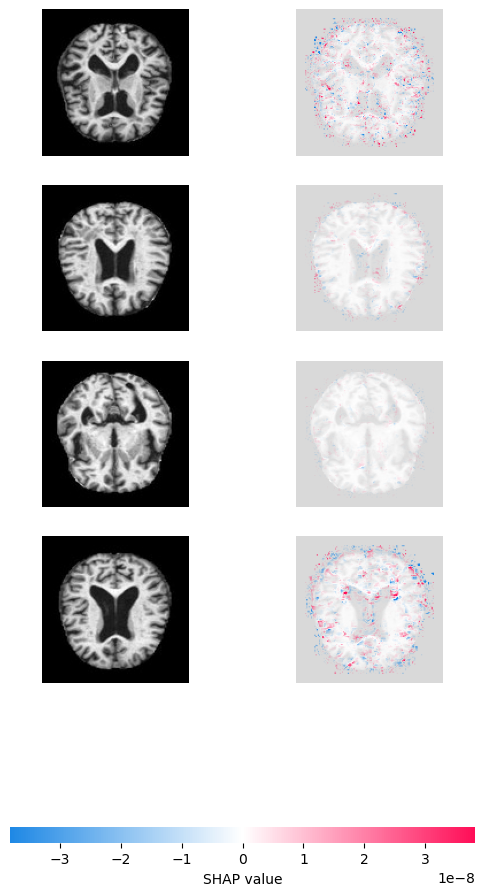

In [26]:
shap_background = X_train[np.random.choice(X_train.shape[0], 100, replace = False)]
test_data = X_val[:4]
true_labels = y_val[:4]

model_explainer = shap.GradientExplainer(model, shap_background)
shap_values = model_explainer.shap_values(test_data)

plt.figure(figsize = (20, 20))

shap.image_plot(shap_values, test_data, show = False)

plt.show()

## SmoothGrad model explainability

In [32]:
def compute_smoothgrad(model, img, class_index = None, num_samples = 50, noise_level = 0.15):
    if (isinstance(img, np.ndarray)):
        img = tf.convert_to_tensor(img, dtype = tf.float32)

    if (len(img.shape) == 3):
        img = tf.expand_dims(img, 0)

    if (class_index is None):
        preds = model(img)[0]
        class_index = tf.argmax(preds).numpy()

    grads_list = []

    for i in range(num_samples):
        noise = noise_level * tf.random.normal(shape = img.shape)
        noisy_img = img + noise

        with tf.GradientTape() as tape:
            tape.watch(noisy_img)
            preds = model(noisy_img)
            loss = preds[:, class_index]

        grads = tape.gradient(loss, noisy_img)[0]
        grads_list.append(grads.numpy())

    smoothgrad = np.mean(grads_list, axis=0)

    if (smoothgrad.ndim == 3 and smoothgrad.shape[-1] > 1):
        smoothgrad = smoothgrad.mean(axis = -1)

    smoothgrad_norm = (smoothgrad - smoothgrad.min()) / (smoothgrad.max() - smoothgrad.min() + 1e-9)

    return smoothgrad_norm

1/1 [==============================] - 0s 204ms/step


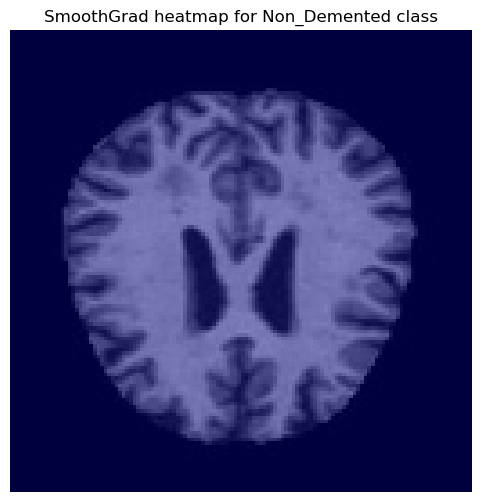

1/1 [==============================] - 0s 128ms/step


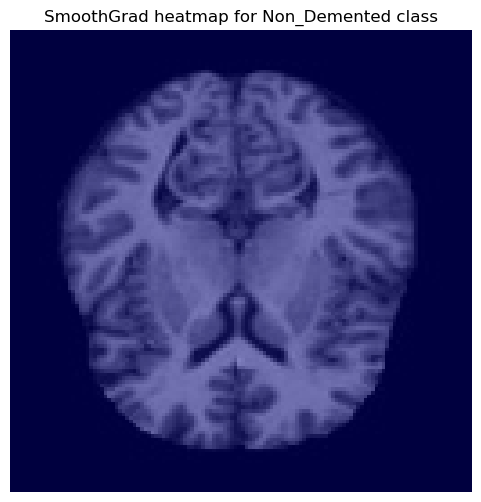

1/1 [==============================] - 0s 115ms/step


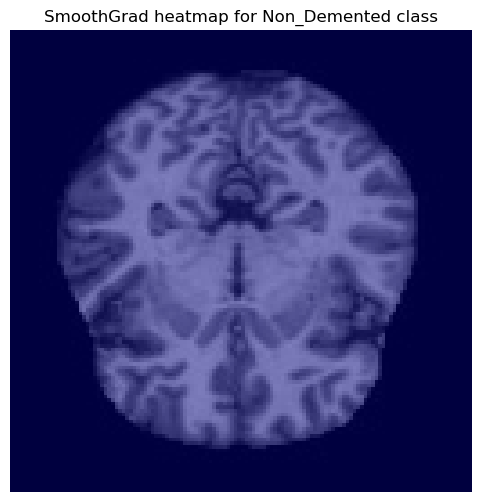

1/1 [==============================] - 0s 105ms/step


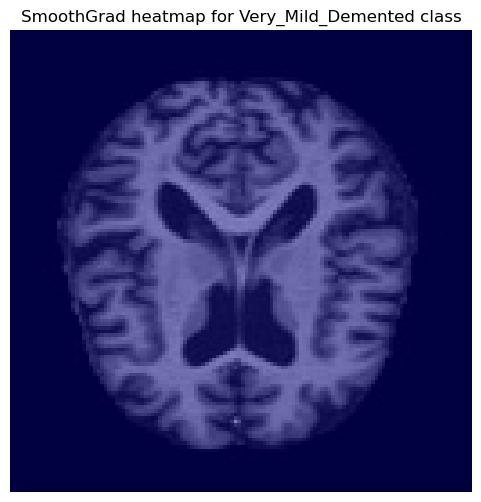

In [46]:
ls = [random.randint(0, 1024) for i in range(4)]

for i in ls:
    img = X_val[i]

    preds = model.predict(img[np.newaxis])[0]
    pred_class = np.argmax(preds)
    
    heatmap = compute_smoothgrad(model, img, class_index = pred_class)
    
    plt.figure(figsize = (6, 6))
    plt.imshow(img.squeeze(), cmap = "gray")
    plt.imshow(heatmap, cmap = "jet", alpha = 0.5)
    plt.title(f"SmoothGrad heatmap for {label_to_class_mapping[pred_class]} class")
    plt.axis("off")
    plt.show()